In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")


In [15]:
users = pd.read_csv('users-processed.csv')
users.head()
users.shape

(6040, 25)

In [16]:
movies = pd.read_csv('movies-processed.csv')
movies.drop(columns=['title'], inplace=True)
movies.head()
movies.shape

(3883, 20)

In [5]:
train = pd.read_csv('training.txt', header=None, names=['userid', 'movieid', 'rating', 'timestamp'])
train.head()

,userid,movieid,rating,timestamp
0,63,3006,4,977899676
1,1125,10,2,975625890
2,181,2384,2,977088920
3,1968,1610,4,974742431
4,4156,2410,4,965342309


In [6]:
train.drop_duplicates(inplace=True)

In [7]:
train.shape

(700146, 4)

In [8]:
merged_train = train.merge(movies, how='left', on='movieid')
merged_train = merged_train.merge(users, how='left', on='userid')
merged_train.head()

,userid,movieid,rating,timestamp,year,Action,Adventure,Animation,Children's,Comedy,...,occupation_retired,occupation_sales/marketing,occupation_scientist,occupation_self-employed,occupation_technician/engineer,occupation_tradesman/craftsman,occupation_unemployed,occupation_writer,gender_F,gender_M
0,63,3006,4,977899676,1999,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1125,10,2,975625890,1995,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,181,2384,2,977088920,1998,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,1
3,1968,1610,4,974742431,1990,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4156,2410,4,965342309,1982,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [10]:
n_users = users['userid'].nunique()
n_movies = movies['movieid'].max()
n_feature_movies = movies.shape[1]
n_feature_users = users.shape[1]

print(n_users, n_movies)
print(n_feature_movies, n_feature_users)

6040 3952
20 25


In [13]:
dim_embedding_user = 50
dim_embedding_movie = 50

movie_input= Input(shape=[n_feature_movies], name='Movie')
movie_embedding = Embedding(n_movies + 1, dim_embedding_movie, name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='Movie-Flatten')(movie_embedding)
movie_vec = Dropout(0.2)(movie_vec)

user_input = Input(shape=[n_feature_users], name='User')
user_embedding = Embedding(n_users + 1, dim_embedding_user, name ='User-Embedding')(user_input)
user_vec = Flatten(name ='User-Flatten')(user_embedding)
user_vec = Dropout(0.2)(user_vec)

concat = concatenate([movie_vec, user_vec])
concat_dropout = Dropout(0.2)(concat)

dense_1 = Dense(20, name ='Fully-Connected1', activation='relu')(concat)

result = Dense(1, activation ='relu',name ='Activation')(dense_1)

model_tabular = Model([user_input, movie_input], result)

model_tabular.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Movie (InputLayer)              (None, 20)           0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 25)           0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 20, 50)       197650      Movie[0][0]                      
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 25, 50)       302050      User[0][0]                       
____________________________________________________________________________________________

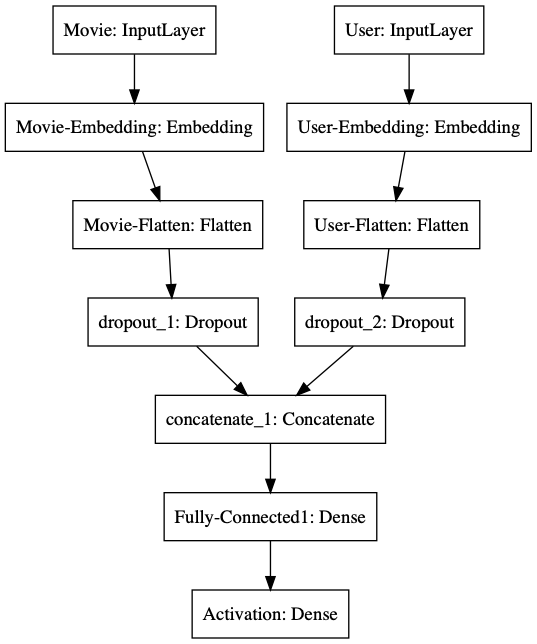

In [14]:
from keras.utils import plot_model
plot_model(model_tabular, to_file='model.png')

In [49]:
model_tabular.compile(optimizer='adam', loss= ['mse'], metrics=['mean_squared_error', 'mean_absolute_error'])

history_tabular = model_tabular.fit([merged_train[users.columns.to_list()], merged_train[movies.columns.to_list()]], merged_train['rating'], epochs=10, batch_size=128, validation_split=0.1, verbose=1)

Train on 630131 samples, validate on 70015 samples
Epoch 1/10
630131/630131 [==============================] - 40s 64us/step - loss: 0.9102 - mean_squared_error: 0.9102 - mean_absolute_error: 0.7546 - val_loss: 0.8483 - val_mean_squared_error: 0.8483 - val_mean_absolute_error: 0.7277
Epoch 2/10
630131/630131 [==============================] - 41s 65us/step - loss: 0.8478 - mean_squared_error: 0.8478 - mean_absolute_error: 0.7292 - val_loss: 0.8440 - val_mean_squared_error: 0.8440 - val_mean_absolute_error: 0.7253
Epoch 3/10
630131/630131 [==============================] - 40s 64us/step - loss: 0.8368 - mean_squared_error: 0.8368 - mean_absolute_error: 0.7226 - val_loss: 0.8327 - val_mean_squared_error: 0.8327 - val_mean_absolute_error: 0.7188
Epoch 4/10
630131/630131 [==============================] - 40s 64us/step - loss: 0.8229 - mean_squared_error: 0.8229 - mean_absolute_error: 0.7158 - val_loss: 0.8167 - val_mean_squared_error: 0.8167 - val_mean_absolute_error: 0.7156
Epoch 5/10
63

In [50]:
test = pd.read_csv('testing.txt', header=None, names=['userid', 'movieid', 'timestamp'])
test.head()

,userid,movieid,timestamp
0,324,2803,976406738
1,4447,1920,965146127
2,4238,3676,965417632
3,4661,368,963867813
4,5078,3471,962416423


In [51]:
merged_test = test.merge(movies, how='left', on='movieid')
merged_test = merged_test.merge(users, how='left', on='userid')
merged_test.head()

,userid,movieid,timestamp,year,Action,Adventure,Animation,Children's,Comedy,Crime,...,occupation_retired,occupation_sales/marketing,occupation_scientist,occupation_self-employed,occupation_technician/engineer,occupation_tradesman/craftsman,occupation_unemployed,occupation_writer,gender_F,gender_M
0,324,2803,976406738,1993,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,4447,1920,965146127,1998,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4238,3676,965417632,1977,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,4661,368,963867813,1994,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,5078,3471,962416423,1977,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [56]:
def get_array(series):
    return np.array([[element] for element in series])

np.array(merged_test[movies.columns.to_list()].values.tolist())

array([[2803, 1993,    0, ...,    1,    0,    0],
       [1920, 1998,    0, ...,    0,    1,    0],
       [3676, 1977,    0, ...,    0,    0,    0],
       ...,
       [1627, 1997,    1, ...,    0,    0,    0],
       [2542, 1998,    0, ...,    1,    0,    0],
       [2606, 1999,    0, ...,    0,    0,    0]])

In [58]:
movies_data = np.array(merged_test[movies.columns.to_list()].values.tolist())
user_data = np.array(merged_test[users.columns.to_list()].values.tolist())
predictions = model_tabular.predict([user_data, movies_data])
predictions_tab = model_tabular.predict([user_data, movies_data])
predictions

array([[2.9174628],
       [1.5557221],
       [3.4595535],
       ...,
       [2.9706013],
       [3.517119 ],
       [2.285692 ]], dtype=float32)

In [60]:
# preds = [a[0] for a in predictions]
preds_tab = [a[0] for a in predictions_tab]
row_ids = list(range(1, len(preds_tab)+1))
# result = pd.DataFrame.from_dict({'ID': row_ids, 'Predicted': preds})
result_tab = pd.DataFrame.from_dict({'ID': row_ids, 'Predicted': preds_tab})
result_tab.head()

,ID,Predicted
0,1,2.917463
1,2,1.555722
2,3,3.459553
3,4,3.795899
4,5,4.307024


In [61]:
# result.to_csv('submission.csv', index=False)
result_tab.to_csv('submission3.csv', index=False)